In [5]:
import pandas as pd 
import re
import matplotlib.pyplot as plt
from gensim.models import LdaModel, CoherenceModel
from wordcloud import WordCloud
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [6]:
with open('먹거리_식품_안전(2017~2012).txt', 'r', encoding = 'utf-8') as f:
    df = f.read()
    # df = df.replace('\n', ' ').replace('\t', ' ')

In [7]:
pattern = re.compile(r"(.+?)\s+(\d{8})\s+(\S+?)\s+(.+?)(?=\n.+?\s+\d{8}\s+\S+\s+|$)", re.DOTALL)
matches = pattern.findall(df)

df = pd.DataFrame(matches, columns=["Title", "Date", "Agency", "Content"])

In [8]:
df1 = df.copy()

In [9]:
df1['Title'] = df1['Title'].str.replace(r'\n', '', regex = True).replace(r'\t', '', regex = True)
df1['text'] = df1['Title'] + " " + df1['Content']

In [10]:
## delete useless symbols

def clean(text):
    text = re.sub(r'[\n\t\r]', ' ', text)    # delete \n, \r, \t
    text = re.sub(r'[^\uAC00-\uD7A3\s]', ' ', text)  # delate Special symbols
    text = re.sub(r'\s+', ' ', text).strip()   # compress spaces
    return text

df1['Cleaned_text'] = df1['text'].apply(clean)

# df1['Cleaned_text'].head()

In [11]:
# Tokenization with Mecab

from konlpy.tag import Mecab

mecab = Mecab(dicpath='/usr/local/lib/mecab/dic/mecab-ko-dic')

def tokenization(Cleaned_text):
    tokens = []
    for word, pos in mecab.pos(Cleaned_text):
        if pos.startswith('N') or pos.startswith('V') or pos == 'VA':  
            tokens.append(word)
    return tokens

df1['tokens'] = df1['Cleaned_text'].apply(tokenization)


In [12]:
with open('stopwords-ko.txt', 'r', encoding = 'utf-8') as sw:
    stopwords = set(sw.read().splitlines())

def remove_stopwords(tokens):
    return [token for token in tokens if token not in stopwords and len(token) > 1 and not token.isdigit()]

df1['tokens_ungram'] = df1['tokens'].apply(remove_stopwords)

In [13]:
# len(stopwords)

In [14]:
# One reason is that each article has fewer words.
# So I think using only A [bi-gram] is better than [tri-gram] or [bi-gram & tri-gram]
# The reason is that [tri-gram] and [bi-gram & tri-gram] could cause overfitting.


# Incompatibility issues exist between Gensim and NumPy/SciPy
# pip install numpy==1.24.4
# pip install scipy==1.10.1
# pip install gensim==4.3.3


bigram = Phrases(df1['tokens_ungram'], min_count=3, threshold=10)
bigram_mod = Phraser(bigram)
df1['bi_gram'] = df1['tokens_ungram'].apply(lambda x: bigram_mod[x])

trigram = Phrases(df1['bi_gram'], min_count=3, threshold=10)
trigram_mod = Phraser(trigram)
df1['tri_gram'] = df1['bi_gram'].apply(lambda x: trigram_mod[x])


In [15]:
# df1.head()

In [16]:
# Construct Dictionary

from gensim.corpora import Dictionary
from gensim.models import TfidfModel

text_ungram = [text for text in df1['tokens_ungram'] if len(text) >= 10]
text_bigrams = [text for text in df1['bi_gram'] if len(text) >= 10]
text_trigrams = [text for text in df1['tri_gram'] if len(text) >= 10]


dictionary_ungram = Dictionary(text_ungram)
dictionary_bigrams = Dictionary(text_bigrams)
dictionary_trigrams = Dictionary(text_trigrams)


dictionary_ungram.filter_extremes(no_below=5, no_above=0.5)  
dictionary_bigrams.filter_extremes(no_below=5, no_above=0.5)  
dictionary_trigrams.filter_extremes(no_below=5, no_above=0.5)  


# Construct Corpus
corpus_ungram = [dictionary_ungram.doc2bow(text) for text in text_ungram]
corpus_bigrams = [dictionary_bigrams.doc2bow(text) for text in text_bigrams]
corpus_trigrams = [dictionary_trigrams.doc2bow(text) for text in text_trigrams]


# TF-IDF
tfidf_ungram = TfidfModel(corpus_ungram)
tfidf_bigrams = TfidfModel(corpus_bigrams)
tfidf_trigrams = TfidfModel(corpus_trigrams)


# Apply TF-IDF corpus
corpus_tfidf_ungram = tfidf_ungram[corpus_ungram]
corpus_tfidf_bigrams = tfidf_bigrams[corpus_bigrams]
corpus_tfdif_trigrams = tfidf_trigrams[corpus_trigrams]

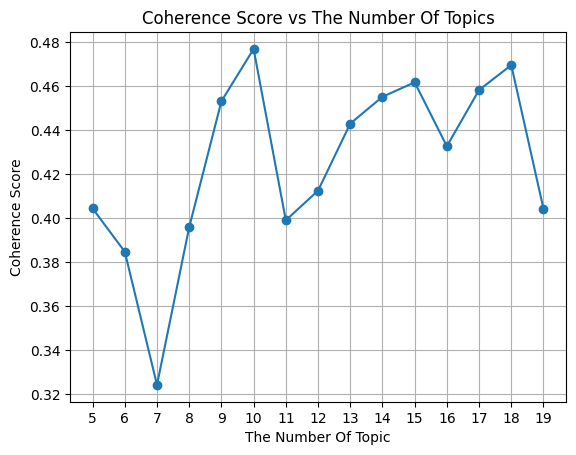

In [ ]:
# compute coherence 

def compute_coherence_values(dictionary, corpus, texts, start=1, limit=20, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, 
                         id2word=dictionary, 
                         num_topics=num_topics, 
                         random_state=42, 
                         passes=20, 
                         alpha='asymmetric')
        model_list.append(model)

        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary_bigrams, corpus_tfidf_bigrams, text_bigrams, start=1, limit=20, step=1)



x = range(1, 20)
plt.plot(x, coherence_values, marker = 'o')
plt.xlabel("The Number Of Topic")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs The Number Of Topics")
plt.xticks(x)
plt.grid(True)
plt.show()


In [24]:
# LDA

LDA = LdaModel(
    corpus = corpus_tfidf_bigrams,
    # corpus = corpus_tfidf_ungram,
    # id2word = dictionary_ungram,
    id2word = dictionary_bigrams,
    num_topics = 4,        # the number of topic 20 -> 10 -> 8
    random_state = 42,     
    passes = 20,           
    # alpha = 'auto',
    alpha = 'asymmetric',         
    per_word_topics = True  
)


i = 0 
doc_topics = LDA.get_document_topics(corpus_tfidf_bigrams[i], minimum_probability=0.01)
# doc_topics = LDA.get_document_topics(corpus_rsw[i], minimum_probability=0.01)
for topic in doc_topics:
    print(topic)

(0, 0.8969876)
(1, 0.044436324)
(2, 0.032678783)
(3, 0.025897324)


In [25]:
topics = LDA.show_topics(num_topics=4, num_words=10, formatted=False)

topic_keywords = []
for topic_no, words in topics:
    keywords = ", ".join([word for word, prob in words])
    topic_keywords.append((topic_no, keywords))

df_cluster_keywords = pd.DataFrame(topic_keywords, columns=["Cluster_No", "Top_Keywords"])
df_cluster_keywords = df_cluster_keywords.sort_values(by='Cluster_No').reset_index(drop=True)

pd.set_option('display.max_colwidth', None)
print(df_cluster_keywords)

   Cluster_No  \
0           0   
1           1   
2           2   
3           3   

                                                                                Top_Keywords  
0                                                   제품, 식약청, 관리, 업체, 위생, 지역, 소비자, 사업, 수입, 위해  
1                                                     과장, 팀장, 정책, 본부, 승진, 부장, 인사, 실장, 기획, 국장  
2  식물_줄기세포, 유기농_수면, 해독_다이어트, 다이어트_성공, 늘어난_뱃살, 다이어트_프로그램, 일본_모스버거, 모스버거_코리아, 기존_패스트푸드, 단기_유기농  
3              남부_출장소, 충북_내수면, 암컷_생산, 부흥기_도래, 민물고기_소비, 이용_메기, 남부_어업, 성화_방지, 붕어_자어, 위해_이스라엘잉어  


In [26]:
cluster_label_mapping = {
    0: '식품, 제품 안전 관리',
    1: '기관 정책, 조직 관리',
    2: '건강, 유기농, 다이어트 트렌드',
    3: '지역 수산업, 내수면 어업 육성'
}


topic_top_terms = {k: LDA.show_topic(k, topn=10) for k in range(LDA.num_topics)}

records = []

for doc_id, corp in enumerate(corpus_tfidf_bigrams):
    topic_probs = LDA.get_document_topics(corp, minimum_probability=0.0)
    topic_probs = sorted(topic_probs, key=lambda x: x[1], reverse=True)
    
    Cluster_topic = topic_probs[0][0]         
    Cluster_prob = topic_probs[0][1]            
    
    if Cluster_prob >= 0.5:
        topic_terms = topic_top_terms[Cluster_topic]
        keywords = ", ".join([term for term, prob in topic_terms])
        
        cluster_label = cluster_label_mapping.get(Cluster_topic, "Unknown")
        
        records.append((doc_id, Cluster_topic, Cluster_prob, keywords, cluster_label))

df_doc_topic_cluster = pd.DataFrame(records, columns=['Doc_No', 'Cluster_No', 'Topic_Probability', 'Top_Keywords', 'Cluster_Label'])
df_doc_topic_cluster = df_doc_topic_cluster.sort_values(by='Topic_Probability', ascending=False).reset_index(drop=True)


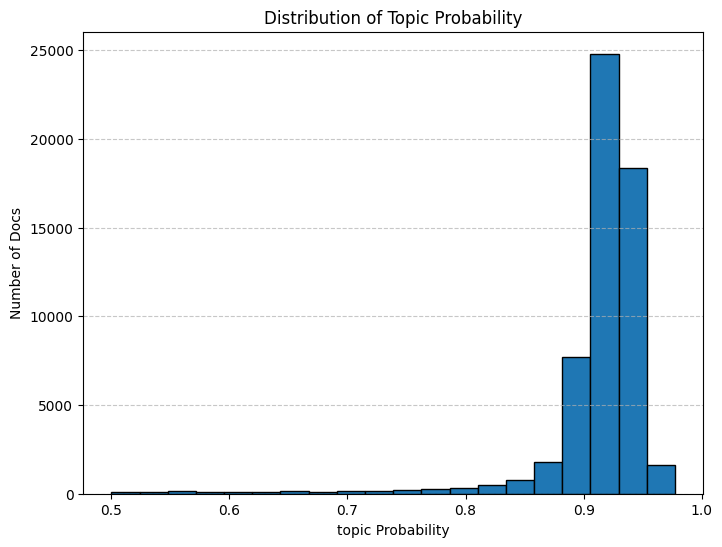

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.hist(df_doc_topic_cluster['Topic_Probability'], bins=20, edgecolor='black')

plt.xlabel('topic Probability')
plt.ylabel('Number of Docs')
plt.title('Distribution of Topic Probability')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [28]:
print("Mean of Topic_Probability:", df_doc_topic_cluster['Topic_Probability'].mean())
print("Median of Topic_Probability:", df_doc_topic_cluster['Topic_Probability'].median())


Mean of Topic_Probability: 0.9120023
Median of Topic_Probability: 0.9220853


In [ ]:
cluster_counts = df_doc_topic_cluster['Cluster_Label'].value_counts().reset_index()
cluster_counts.columns = ['Cluster_Label', 'Doc_Count']
total_docs = df_doc_topic_cluster.shape[0]
cluster_counts['Percentage'] = (cluster_counts['Doc_Count'] / total_docs * 100).round(2)
cluster_counts = cluster_counts.sort_values(by='Doc_Count', ascending=False).reset_index(drop=True)

print(cluster_counts)

       Cluster_Label  Doc_Count  Percentage
0       식품, 제품 안전 관리      54167       94.12
1       기관 정책, 조직 관리       3258        5.66
2  건강, 유기농, 다이어트 트렌드        128        0.22


In [30]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

pyLDAvis.enable_notebook()
# pyLDAvis.save_html(vis, 'lda.html')

vis = gensimvis.prepare(LDA, corpus_tfidf_bigrams, dictionary_bigrams)
pyLDAvis.display(vis)

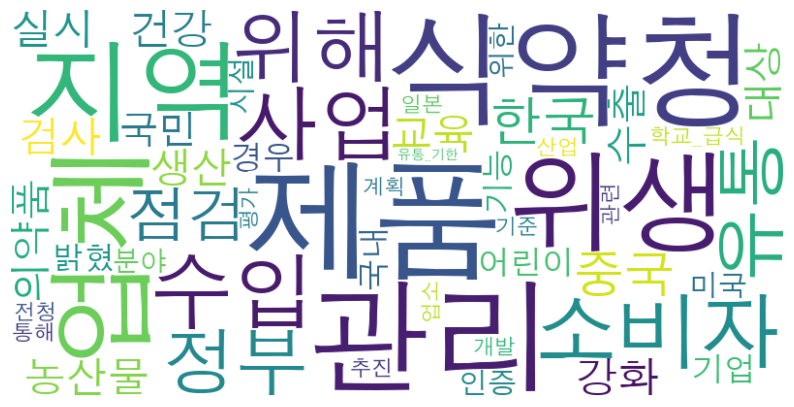

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


topic_words = dict(LDA.show_topic(0, topn=50))

wordcloud = WordCloud(font_path='/System/Library/Fonts/AppleGothic.ttf', 
                      background_color='white',
                      width = 800,
                      height = 400).generate_from_frequencies(topic_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

/Users/changlongkim/Desktop/Midterm/midterm/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


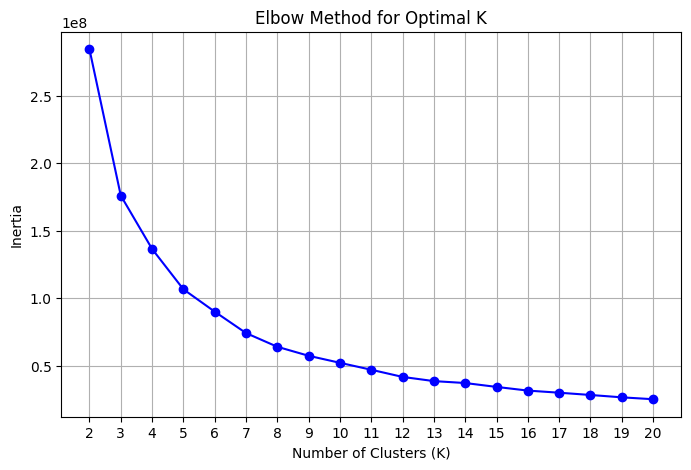

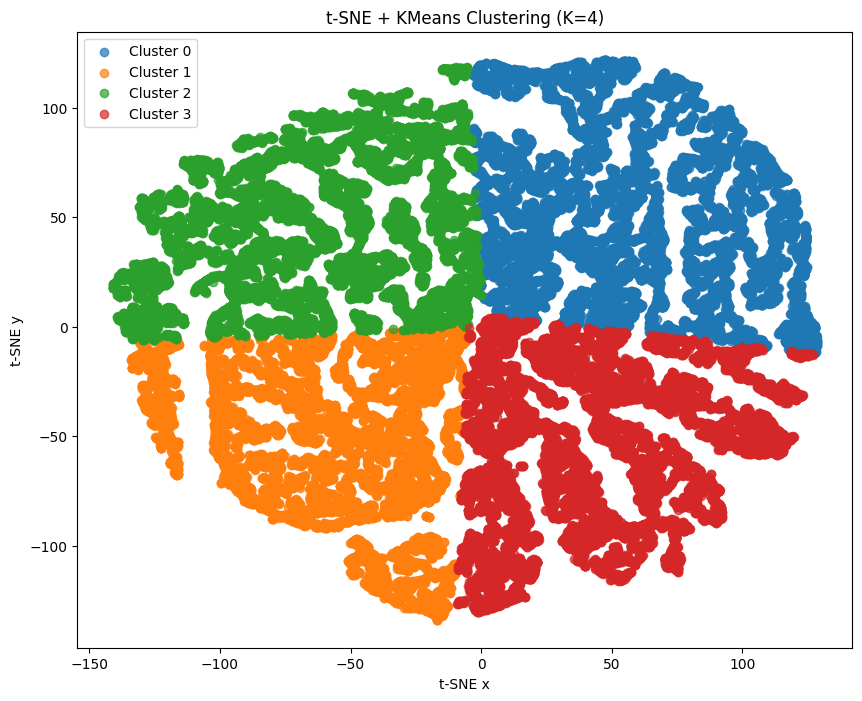

In [32]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd


topic_distributions = []

for bow in corpus_tfidf_ungram: 
    doc_topics = LDA.get_document_topics(bow, minimum_probability=0)
    topic_vector = [prob for _, prob in doc_topics]
    topic_distributions.append(topic_vector)

topic_df = pd.DataFrame(topic_distributions)

tsne_model = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_values = tsne_model.fit_transform(topic_df)


inertia = []  
K_range = range(2, 21)  

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tsne_values)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.xticks(K_range)
plt.grid()
plt.show()


best_k = 4

kmeans_model = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans_model.fit_predict(tsne_values)


tsne_df = pd.DataFrame(tsne_values, columns=['x', 'y'])
tsne_df['cluster'] = clusters


plt.figure(figsize=(10, 8))
for cluster in sorted(tsne_df['cluster'].unique()):
    cluster_data = tsne_df[tsne_df['cluster'] == cluster]
    plt.scatter(cluster_data['x'], cluster_data['y'], label=f'Cluster {cluster}', alpha=0.7)

plt.legend()
plt.title(f't-SNE + KMeans Clustering (K={best_k})')
plt.xlabel('t-SNE x')
plt.ylabel('t-SNE y')
plt.show()


In [34]:
df1.columns

Index(['Title', 'Date', 'Agency', 'Content', 'text', 'Cleaned_text', 'tokens',
       'tokens_ungram', 'bi_gram', 'tri_gram'],
      dtype='object')

In [17]:
# DMR

# pip install tomotopy

import tomotopy as tp


dmr_model = tp.DMRModel(k=4)


# for tokens, agency, date in zip(df1['tokens_ungram'], df1['Agency'], df1['Date']):
for tokens, agency, date in zip(df1['bi_gram'], df1['Agency'], df1['Date']):
    year_month = str(date)[:6]  
    metadata = f'{agency}_{year_month}'  
    dmr_model.add_doc(tokens, metadata=metadata)



dmr_model.train(0)
for i in range(0, 1000, 100):
    dmr_model.train(100)
    print(f'Iteration: {i+100}\tLog-likelihood: {dmr_model.ll_per_word}')


for k in range(dmr_model.k):
    print(f'\n\nTopic #{k}')
    print(dmr_model.get_topic_words(k, top_n=10))


Iteration: 100	Log-likelihood: -9.424017116181481
Iteration: 200	Log-likelihood: -9.391646961128867
Iteration: 300	Log-likelihood: -9.368829851790702
Iteration: 400	Log-likelihood: -9.358896820614248
Iteration: 500	Log-likelihood: -9.355004664131904
Iteration: 600	Log-likelihood: -9.353917189059654
Iteration: 700	Log-likelihood: -9.352893857768207
Iteration: 800	Log-likelihood: -9.3525494539842
Iteration: 900	Log-likelihood: -9.351897934001451
Iteration: 1000	Log-likelihood: -9.351781262149428


Topic #0
[('식품', 0.014720113016664982), ('기업', 0.0068920087069272995), ('생산', 0.006574537139385939), ('지역', 0.006507060490548611), ('사업', 0.006495999172329903), ('산업', 0.0059243845753371716), ('중국', 0.005531140137463808), ('시장', 0.005158360116183758), ('한국', 0.004751565400511026), ('안전', 0.004628503695130348)]


Topic #1
[('제품', 0.01452273316681385), ('식품', 0.013613871298730373), ('안전', 0.006779015995562077), ('건강', 0.005065286532044411), ('국내', 0.0046038334257900715), ('미국', 0.0045326091349124

In [18]:
doc_records = []

for doc_id, doc in enumerate(dmr_model.docs):
    topic_probs = doc.get_topic_dist()
    topic_probs = list(enumerate(topic_probs))
    topic_probs = sorted(topic_probs, key=lambda x: x[1], reverse=True)
    
    dominant_topic = topic_probs[0][0]
    dominant_prob = topic_probs[0][1]
    
    doc_records.append((doc_id, dominant_topic, dominant_prob))

df_doc_topics = pd.DataFrame(doc_records, columns=['Doc_No', 'Doc_Topic', 'topic_probs'])


In [19]:
topic_keywords = {}

for topic_id in range(dmr_model.k):
    keywords = ", ".join([word for word, _ in dmr_model.get_topic_words(topic_id, top_n=10)])
    topic_keywords[topic_id] = keywords

df_doc_topics['Top_Keywords'] = df_doc_topics['Doc_Topic'].map(topic_keywords)


In [20]:
df_doc_topics['Agency'] = df1['Agency'].values
df_doc_topics['Date'] = df1['Date'].values

print(df_doc_topics.head())


   Doc_No  Doc_Topic  topic_probs                            Top_Keywords  \
0       0          3     0.904218  과장, 정책, 관리, 팀장, 본부, 안전, 사업, 교육, 부장, 행정   
1       1          2     0.817106  식품, 안전, 관리, 정부, 위생, 국민, 교육, 지역, 점검, 강화   
2       2          2     0.661473  식품, 안전, 관리, 정부, 위생, 국민, 교육, 지역, 점검, 강화   
3       3          0     0.948134  식품, 기업, 생산, 지역, 사업, 산업, 중국, 시장, 한국, 안전   
4       4          2     0.830340  식품, 안전, 관리, 정부, 위생, 국민, 교육, 지역, 점검, 강화   

  Agency      Date  
0   한국일보  20171031  
1   경상일보  20171031  
2   울산매일  20171031  
3   경향신문  20171031  
4   중도일보  20171031  


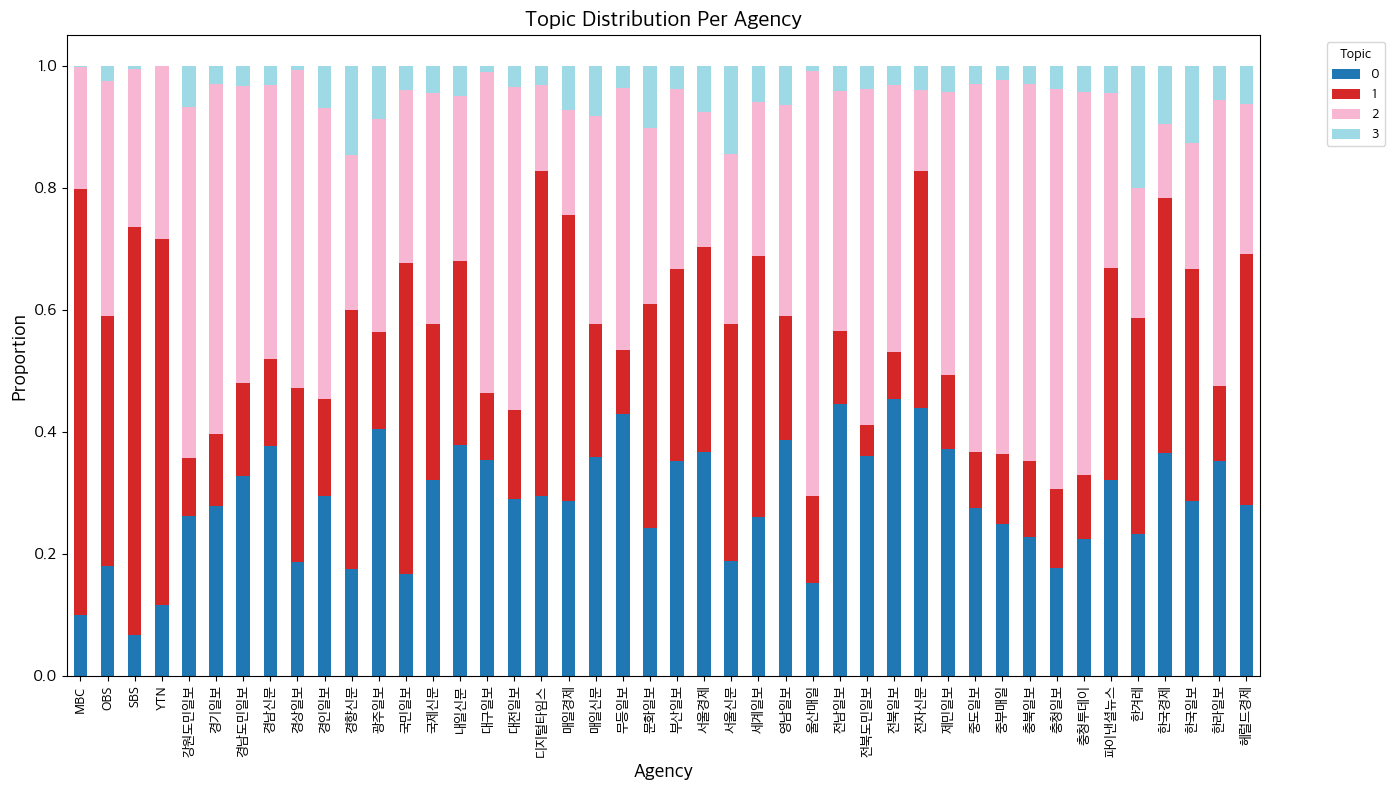

In [21]:
agency_topic_dist = df_doc_topics.groupby(['Agency', 'Doc_Topic']).size().unstack(fill_value=0)
agency_topic_dist_percent = agency_topic_dist.div(agency_topic_dist.sum(axis=1), axis=0)

font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

agency_topic_dist_percent.plot(kind='bar', 
                               stacked=True, 
                               figsize=(14,8), 
                               colormap='tab20')

plt.title('Topic Distribution Per Agency', fontsize=16)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Agency', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


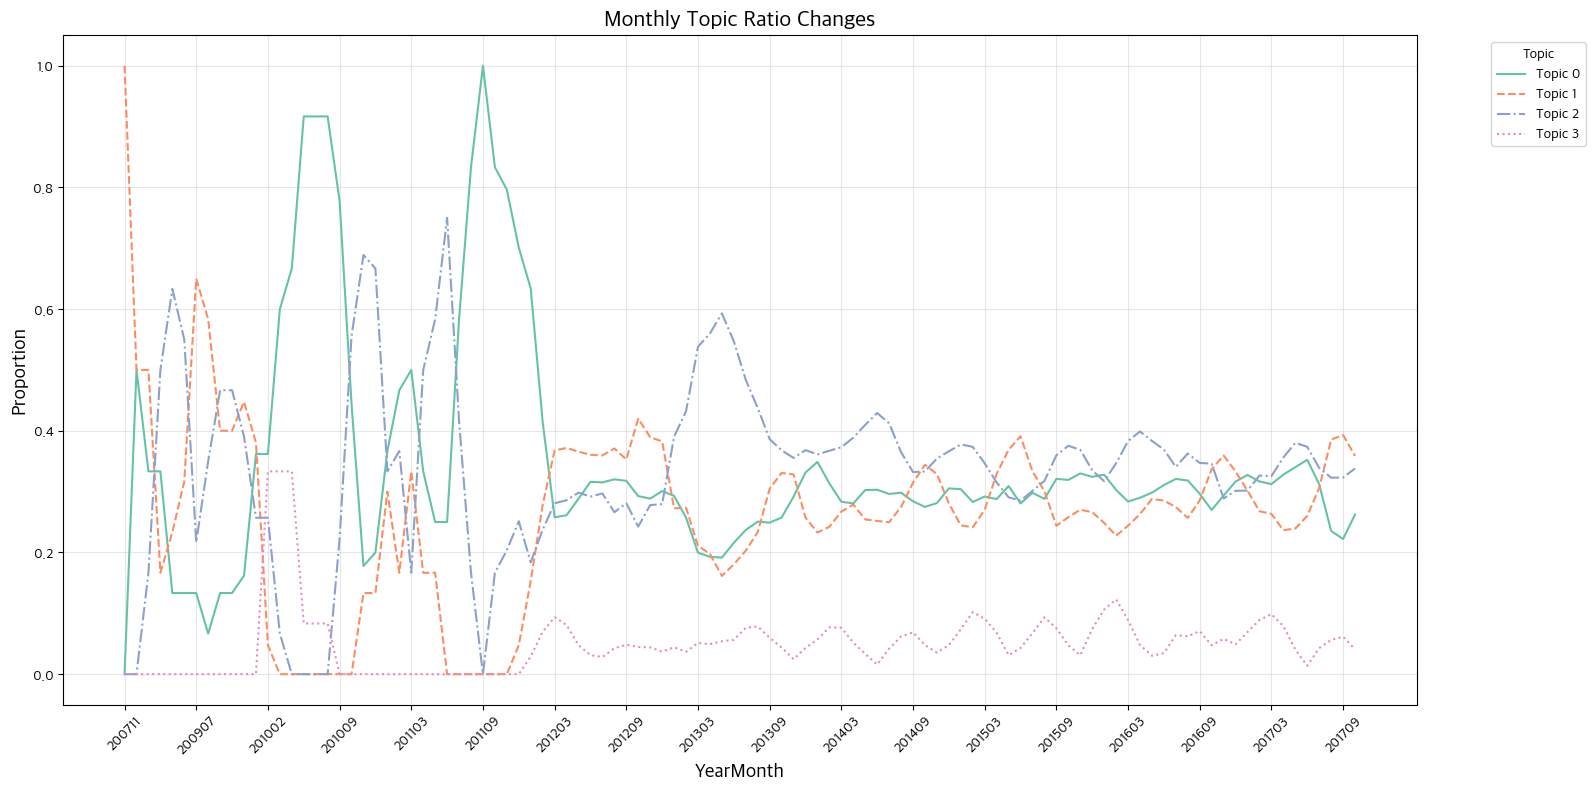

In [22]:
df_doc_topics['YearMonth'] = df_doc_topics['Date'].astype(str).str[:6]
date_topic_dist = df_doc_topics.groupby(['YearMonth', 'Doc_Topic']).size().unstack(fill_value=0)
date_topic_dist_percent = date_topic_dist.div(date_topic_dist.sum(axis=1), axis=0)
smoothed = date_topic_dist_percent.rolling(window=3, min_periods=1).mean()

xtick_interval = 6  

plt.figure(figsize=(16,8))

colors = sns.color_palette('Set2', n_colors=len(smoothed.columns))
linestyles = ['-', '--', '-.', ':'] * 3  

for i, topic in enumerate(smoothed.columns):
    plt.plot(smoothed.index, smoothed[topic],
             label=f'Topic {topic}',
             color=colors[i],
             linestyle=linestyles[i])

plt.title('Monthly Topic Ratio Changes', fontsize=16)
plt.xlabel('YearMonth', fontsize=14)
plt.ylabel('Proportion', fontsize=14)

plt.xticks(
    ticks=range(0, len(smoothed.index), xtick_interval),
    labels=smoothed.index[::xtick_interval],
    rotation=45,
    fontsize=10
)

plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [23]:
agency_topic_count = df_doc_topics.groupby(['Agency', 'Doc_Topic']).size().unstack(fill_value=0)

agency_topic_ratio = agency_topic_count.div(agency_topic_count.sum(axis=1), axis=0)

agency_top_topic = agency_topic_ratio.idxmax(axis=1)  
agency_top_topic_prob = agency_topic_ratio.max(axis=1)  

df_agency_top_topic = pd.DataFrame({
    'Agency': agency_top_topic.index,
    'Top_Topic': agency_top_topic.values,
    'Top_Topic_Proportion': agency_top_topic_prob.values
})

print(df_agency_top_topic.head())


   Agency  Top_Topic  Top_Topic_Proportion
0     MBC          1              0.698957
1     OBS          1              0.410256
2     SBS          1              0.669725
3     YTN          1              0.600000
4  강원도민일보          2              0.575058


In [24]:
topic_agency_count = df_doc_topics.groupby(['Doc_Topic', 'Agency']).size()
top_agency_per_topic = topic_agency_count.groupby('Doc_Topic').idxmax()
top_agency_doccount = topic_agency_count.groupby('Doc_Topic').max()

df_topic_top_agency = pd.DataFrame({
    'Topic': [i[0] for i in top_agency_per_topic],
    'Top_Agency': [i[1] for i in top_agency_per_topic],
    'Doc_Count': top_agency_doccount.values
})

print(df_topic_top_agency.head())


   Topic Top_Agency  Doc_Count
0      0     파이낸셜뉴스       1410
1      1      헤럴드경제       1767
2      2      충청투데이       1657
3      3      헤럴드경제        266


In [25]:
agency_topic_count = df_doc_topics.groupby(['Agency', 'Doc_Topic']).size().unstack(fill_value=0)
agency_topic_ratio = agency_topic_count.div(agency_topic_count.sum(axis=1), axis=0)

agency_top_topic = agency_topic_ratio.idxmax(axis=1)
agency_top_topic_prob = agency_topic_ratio.max(axis=1)

df_agency_top_topic = pd.DataFrame({
    'Agency': agency_top_topic.index,
    'Top_Topic': agency_top_topic.values,
    'Top_Topic_Proportion': agency_top_topic_prob.values
})

print(df_agency_top_topic.head())


   Agency  Top_Topic  Top_Topic_Proportion
0     MBC          1              0.698957
1     OBS          1              0.410256
2     SBS          1              0.669725
3     YTN          1              0.600000
4  강원도민일보          2              0.575058


In [26]:
topic_agency_count = df_doc_topics.groupby(['Doc_Topic', 'Agency']).size()

top_agency_per_topic = topic_agency_count.groupby('Doc_Topic').idxmax()
top_agency_doccount = topic_agency_count.groupby('Doc_Topic').max()

df_topic_top_agency = pd.DataFrame({
    'Topic': [i[0] for i in top_agency_per_topic],
    'Top_Agency': [i[1] for i in top_agency_per_topic],
    'Doc_Count': top_agency_doccount.values
})

print(df_topic_top_agency.head())


   Topic Top_Agency  Doc_Count
0      0     파이낸셜뉴스       1410
1      1      헤럴드경제       1767
2      2      충청투데이       1657
3      3      헤럴드경제        266


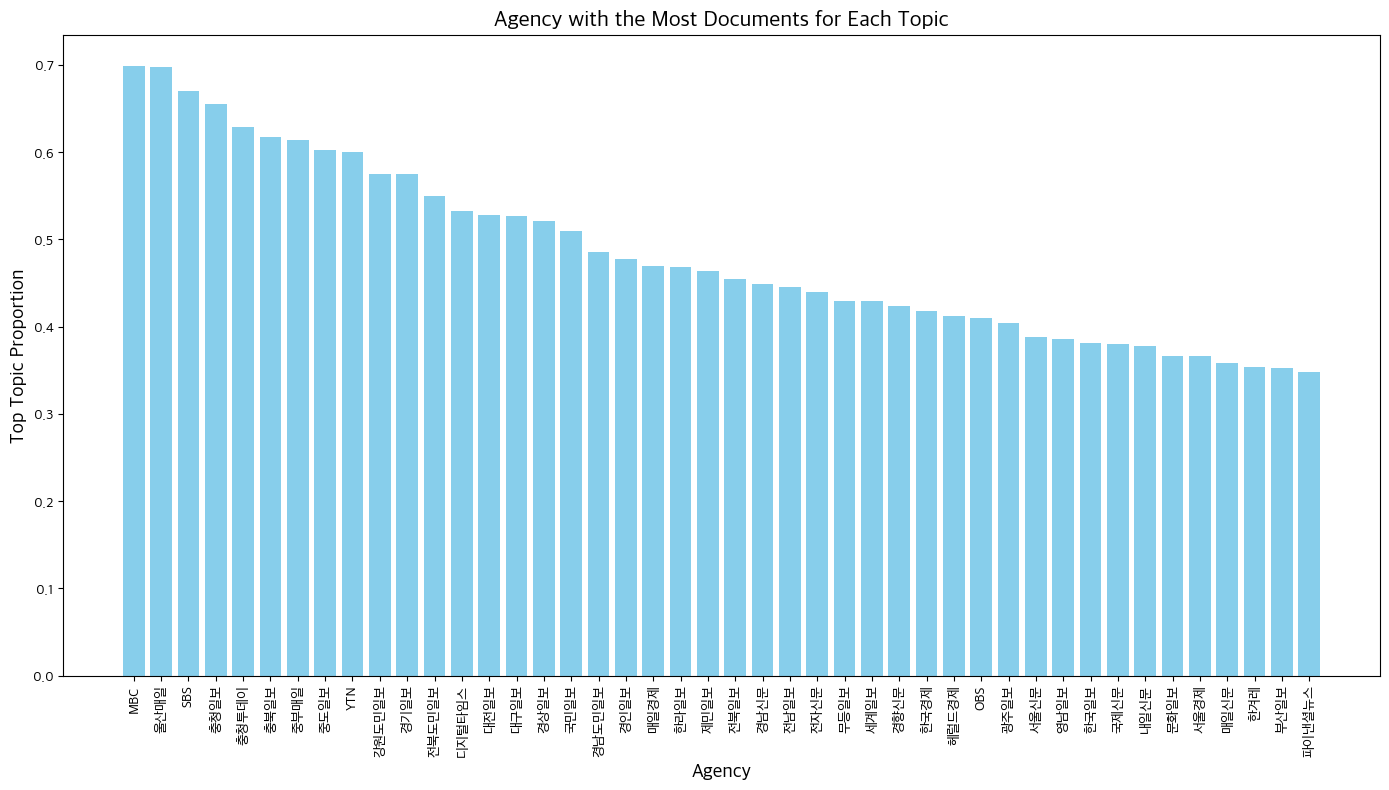

In [27]:
font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

df_agency_top_topic_sorted = df_agency_top_topic.sort_values(by='Top_Topic_Proportion', ascending=False)

plt.figure(figsize=(14,8))
plt.bar(df_agency_top_topic_sorted['Agency'], df_agency_top_topic_sorted['Top_Topic_Proportion'], color='skyblue')
plt.xticks(rotation=90, fontsize=10)
plt.xlabel('Agency', fontsize=14)
plt.ylabel('Top Topic Proportion', fontsize=14)
plt.title('Agency with the Most Documents for Each Topic', fontsize=16)
plt.tight_layout()
plt.show()


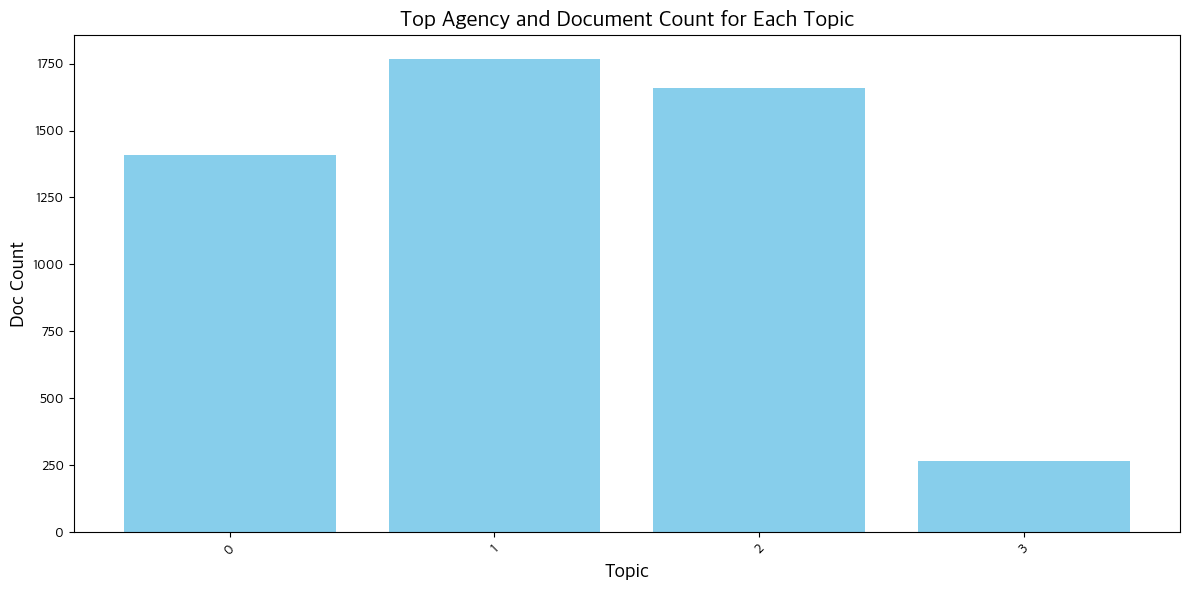

In [28]:
plt.figure(figsize=(12,6))
plt.bar(df_topic_top_agency['Topic'].astype(str), df_topic_top_agency['Doc_Count'], color='skyblue')
plt.xlabel('Topic', fontsize=14)
plt.ylabel('Doc Count', fontsize=14)
plt.title('Top Agency and Document Count for Each Topic', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [29]:
df_high_confidence = df_doc_topics[df_doc_topics['topic_probs'] > 0.7].copy()

print(f"The total number: {len(df_doc_topics)}")
print(f"Topic_Prob > 0.7 the number of document: {len(df_high_confidence)}")

df_high_confidence.head()


The total number: 57715
Topic_Prob > 0.7 the number of document: 42222


,Doc_No,Doc_Topic,topic_probs,Top_Keywords,Agency,Date,YearMonth
0,0,3,0.904218,"과장, 정책, 관리, 팀장, 본부, 안전, 사업, 교육, 부장, 행정",한국일보,20171031,201710
1,1,2,0.817106,"식품, 안전, 관리, 정부, 위생, 국민, 교육, 지역, 점검, 강화",경상일보,20171031,201710
3,3,0,0.948134,"식품, 기업, 생산, 지역, 사업, 산업, 중국, 시장, 한국, 안전",경향신문,20171031,201710
4,4,2,0.830340,"식품, 안전, 관리, 정부, 위생, 국민, 교육, 지역, 점검, 강화",중도일보,20171031,201710
6,6,2,0.868044,"식품, 안전, 관리, 정부, 위생, 국민, 교육, 지역, 점검, 강화",전북도민일보,20171031,201710


In [30]:
a = 40820 / 57710
print(a)

0.7073297522093225


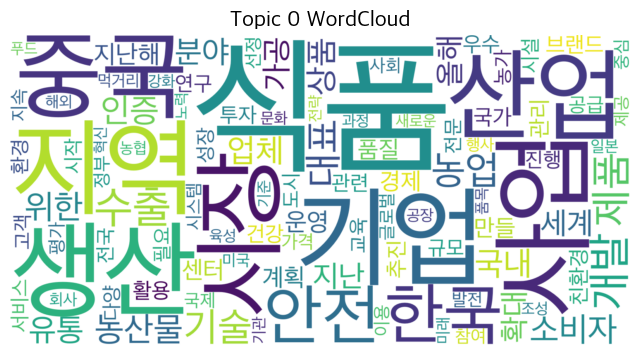

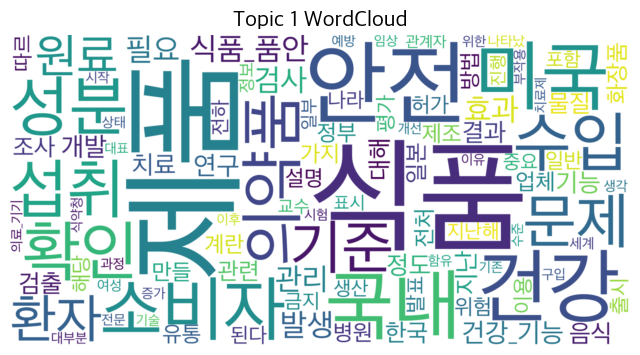

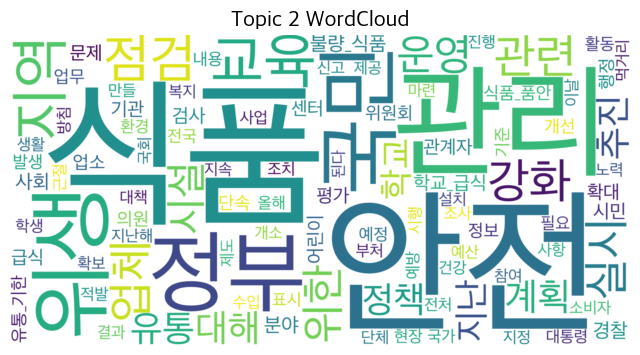

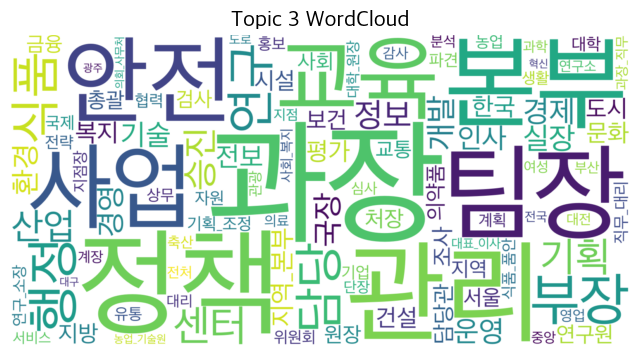

In [31]:
from wordcloud import WordCloud

for topic_id in range(dmr_model.k):
    plt.figure(figsize=(8, 6))
    
    topic_words = dmr_model.get_topic_words(topic_id, top_n = 100)
    word_freq = {word: weight for word, weight in topic_words}
    
    wordcloud = WordCloud(font_path='/System/Library/Fonts/AppleSDGothicNeo.ttc',
                          width=1600, height=800, background_color='white').generate_from_frequencies(word_freq)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_id} WordCloud", fontsize=16)
    plt.show()


In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from matplotlib import font_manager as fm
font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc'  
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)


for topic_id in range(4):  
    plt.figure(figsize=(6, 4))
    topic_words = dict(LDA.show_topic(topic_id, topn=100))  
    wordcloud = WordCloud(font_path=font_path,
                          background_color='white',
                          width=800,
                          height=400).generate_from_frequencies(topic_words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic_id} WordCloud", fontsize=14)
    plt.show()


NameError: name 'LDA' is not defined

<Figure size 600x400 with 0 Axes>

In [ ]:
df_doc_topics_sorted = df_doc_topics.sort_values(by=['Doc_Topic', 'topic_probs'], ascending=[True, False])

top3_docs_per_topic = df_doc_topics_sorted.groupby('Doc_Topic').head(3)

print(top3_docs_per_topic[['Doc_No', 'Doc_Topic', 'topic_probs']])

       Doc_No  Doc_Topic  topic_probs
15891   15891          0     0.999832
50507   50507          0     0.999807
48683   48683          0     0.999761
2876     2876          1     0.999548
2891     2891          1     0.999486
2879     2879          1     0.999428
16174   16174          2     0.999947
17007   17007          2     0.999900
49308   49308          2     0.999878
52827   52827          3     0.999769
30754   30754          3     0.999746
30753   30753          3     0.999745


In [33]:
# Topic–Word Network (Edge)

topic_word_edges = []
for topic_id in range(dmr_model.k):
    for word, prob in dmr_model.get_topic_words(topic_id, top_n=10):
        topic_word_edges.append({
            "Source": f"topic_{topic_id}",
            "Target": word,
            "Type": "Undirected",
            "Weight": round(prob, 4)
        })

df_topic_word_edges = pd.DataFrame(topic_word_edges)
df_topic_word_edges.to_csv("topic_word_edges.csv", index=False, encoding="utf-8-sig")


In [34]:
# Agency–Topic

agency_topic_edges = []
for doc in dmr_model.docs:
    agency = doc.metadata.split('_')[0]  
    top_topic = max(enumerate(doc.get_topic_dist()), key=lambda x: x[1])[0]
    agency_topic_edges.append({
        "Source": agency,
        "Target": f"topic_{top_topic}",
        "Type": "Undirected",
        "Weight": 1
    })

df_agency_topic_edges = pd.DataFrame(agency_topic_edges)
df_agency_topic_edges.to_csv("agency_topic_edges.csv", index=False, encoding="utf-8-sig")


In [35]:
# combine all nodes 

topics = set(df_topic_word_edges['Source']).union(df_agency_topic_edges['Target'])
words = set(df_topic_word_edges['Target'])
agencies = set(df_agency_topic_edges['Source'])

nodes = []

for topic in topics:
    nodes.append({"Id": topic, "Label": topic, "Type": "Topic"})

for word in words:
    nodes.append({"Id": word, "Label": word, "Type": "Word"})

for agency in agencies:
    nodes.append({"Id": agency, "Label": agency, "Type": "Agency"})

df_nodes = pd.DataFrame(nodes)
df_nodes.to_csv("gephi_nodes.csv", index=False, encoding="utf-8-sig")
